In [6]:
from Bio import motifs
from Bio.Seq import Seq
import logomaker

import pandas as pd
import numpy as np
import time
import itertools
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec
from scipy.stats import kruskal

import aaanalysis as aa
aa.options["verbose"] = False
aa.options["random_state"] = 42

from rulekit.classification import RuleClassifier, ExpertRuleClassifier
from rulekit.params import Measures
from rulekit._helpers import *
from jpype.pickle import JPickler, JUnpickler

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.model_selection import train_test_split
from src.utils import *
from src.utils_rules import *
from src.MHCRule import *

In [3]:
# Read training data
BA_df = pd.read_csv('./Data/Data_HLA.csv', index_col=0)
BA_df = BA_df[BA_df['peptide_length']==9].reset_index(drop=True)

# Read count df
count_df = pd.read_csv('./Data/HLA_peptide_count.csv',index_col=0)

# HLA list
# Make sure we have atleast 10 peptides with atleast 6 +ve and -ve peptides
allele_ls = count_df[(count_df['positives']>5)&(count_df['negatives']>5)&(count_df['total']>10)]['allele'].to_list()

df_scales = aa.load_scales()
_ = RuleClassifier()

scale = 'KOEH090101'

Jun 24, 2024 8:33:34 PM com.rapidminer.tools.I18N <clinit>
INFO: Set locale to en.


## Rule coverage

In [7]:
relevant_rules_ls_ = []
rules_position_ls_ = []
allele_ls_ = []

# train classifier
with open('./model/MHCRulePepOnly.pkl','rb') as f:
    peponly = pickle.load(f)
    
f.close()

with open('./model/MHCRuleHydro.pkl','rb') as f:
    hydro = pickle.load(f)
    
f.close()

for allele in tqdm(allele_ls):

        allele_ls_ = allele_ls_ + [allele]
        rules_ls = [str(rule) for rule in peponly.get_rules(allele) if '{1}' in str(rule)]
        relevant_rules_ls_ = relevant_rules_ls_ + [rules_ls]

        # get all conditions
        conditions_ls = [get_rule_condition(rule) for rule in rules_ls]

        # get positions used by rules
        rules_position_ls_seq = [int(condition[0][3]) for condition in conditions_ls]
        
        ###########
        rules_ls = [str(rule) for rule in hydro.get_rules(allele) if '{1}' in str(rule)]
        
        # Get covering rules that have label 1
        relevant_rules_ls_ = relevant_rules_ls_ + [rules_ls]

        # get all conditions
        conditions_ls = [get_rule_condition(rule) for rule in rules_ls]

        # get positions used by rules
        rules_position_ls_scale = [int(condition[0][3]) for condition in conditions_ls]
        
        rules_position_ls = rules_position_ls_seq + rules_position_ls_scale
        
        rules_position_ls_ = rules_position_ls_ + [rules_position_ls]
        
        
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 219.18it/s]


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


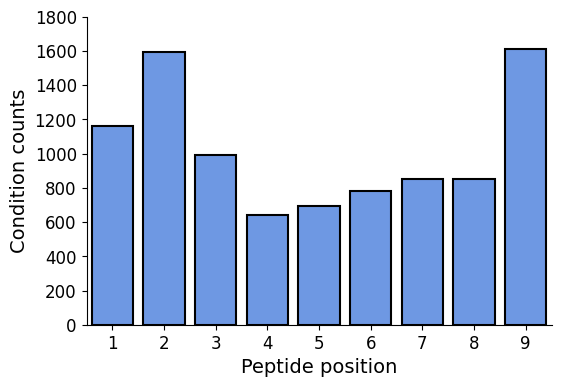

In [8]:
global_relevant_ls = [item for sublist in relevant_rules_ls_ if sublist for item in sublist]
global_conditions_ls = [get_rule_condition(rule) for rule in global_relevant_ls]
global_conditions_ls = [item for sublist in global_conditions_ls if sublist for item in sublist]
global_positions_ls = [int(i[3]) for i in global_conditions_ls]

fig,axs = plt.subplots(1,1,figsize=(6,4))
fontsize = 14
dpi = 600
b = sns.countplot(x=global_positions_ls, saturation = 0.85, linewidth=1.5,edgecolor='black',
               color='CornflowerBlue',ax=axs)

b.set_ylabel('Condition counts', fontsize=fontsize)
b.set_xlabel('Peptide position', fontsize=fontsize)
b.set(ylim=(0,1800))

# Adding labels 
# Retrieve and modify existing y-axis tick labels fontsize
yticklabels = b.get_yticklabels()
for label in yticklabels:
    label.set_fontsize(fontsize-2)  # Set fontsize to 10
    
xticklabels = [i.get_text() for i in b.get_xticklabels()]
b.set_xticklabels(xticklabels,fontsize=fontsize-2,rotation=0)
sns.despine(top=True, right=True)

fig.savefig('./figures/rule_conditions/condition_count.png',bbox_inches='tight', dpi=dpi)